In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import datetime as dt
import glob
import os
import Model
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [3]:
total=pd.read_csv('total_series.csv')
total_data=total.values
print(total_data.shape)

(262800, 10)


In [4]:
# print(data[0:259200].sum())
T=10
step=10
abnormal=[]
for i in range(10):
    Y0=total_data[0:259200+T+step,i]
    y_label=np.zeros((len(Y0)))
    y_label[Y0>18]=1
    mil_label=np.zeros((25920))
    for i in range(len(mil_label)):
        for j in range(step):
            if y_label[i*10+T+j]==1:
                mil_label[i]=1
                break
    abnormal.append(mil_label.sum())
print(np.array(abnormal).sum())
print(abnormal)

721.0
[27.0, 135.0, 36.0, 82.0, 104.0, 68.0, 90.0, 30.0, 78.0, 71.0]


(149220, 6)
(149220,)
149200
409.0
152.0
(3600, 20, 6)
(3600, 20)
247.0
137.0


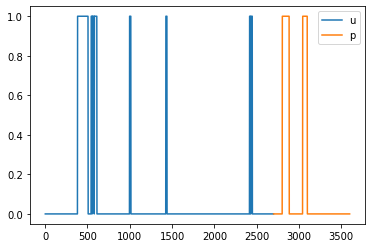

In [5]:
T=10
step=10
TRAINSIZE= 2700
BATCH_SIZE=300
EPOCH=4000

a=[0,1,3,4,5,6]
b=2

X0=total_data[0:149200+T+step,a]
Y0=total_data[0:149200+T+step,b]
print(X0.shape)
print(Y0.shape)

y_label=np.zeros((len(Y0)))
y_label[Y0>15]=1

mil_label=np.zeros((149200))

for i in range(len(mil_label)):
    for j in range(step):
        if y_label[i+T+j]==1:
            mil_label[i]=1
            break
print(len(mil_label))
print(mil_label.sum())
print(y_label.sum())


X1=[]
Y1=[]
index=[]
mil_label1=mil_label[0:127600]
for i in range(len(mil_label1)):
    if len(X1)<3600:
        if i%35==0 or mil_label1[i]==1:
            X1.append(X0[i:i+T+step,:])
            Y1.append(Y0[i:i+T+step])
            index.append(i)

X1=np.array(X1)
Y1=np.array(Y1)
mil_train_label=mil_label[index]

print(X1.shape)
print(Y1.shape)

ROW=X1.shape[0]
COLUMN=X1.shape[2]


sample0=len(Y1)
sample1=TRAINSIZE


y_train_label=mil_train_label[0:sample1]
y_valid_label=mil_train_label[sample1:sample0]
print(y_train_label.sum())
print(y_valid_label.sum())

plt.figure()
plt.plot(range(1,1+len(y_train_label)),y_train_label)
plt.plot(range(1+len(y_train_label),1+len(y_train_label)+len(y_valid_label)),y_valid_label)
plt.legend('upper right')
plt.show()


In [6]:
# network parameter
in_dim = COLUMN
out_dim = 1
encoder_hidden_size = 32  # rnn hidden size
decoder_hidden_size= 32
fc_hidden_size = 64

In [7]:
model = Model.da_mil(in_dim,T,encoder_hidden_size,decoder_hidden_size,fc_hidden_size,out_dim).cuda()

In [8]:
weight_p,bias_p=[],[]
for name,p in model.named_parameters():
    if 'bias' in name:
        bias_p.append(p)
    else:
        weight_p.append(p)

In [9]:
# TRAIN
k1=0.0000
learning_rate=0.002
criterion = torch.nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0110)
optimizer=torch.optim.Adam([{ 'params':weight_p,'weight_decay':0.000},
                            { 'params':bias_p,'weight_decay':0}],
                            lr=learning_rate)

In [10]:
def predict(on_train = False):
        if on_train:
            y_pred = np.zeros((sample1))
        else:
            y_pred = np.zeros((sample0-sample1))

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + BATCH_SIZE)]
            X = np.zeros((len(batch_idx), T +step, COLUMN))
            y_history = np.zeros((len(batch_idx),T +step))
            for j in range(len(batch_idx)):
                if on_train:
#                     X[j, :, :] = X1[range(batch_idx[j], batch_idx[j] + T +step), :]
#                     y_history[j, :] = Y1[range(batch_idx[j],  batch_idx[j]+ T +step)]
                    X=X1[batch_idx]
                    y_history=Y1[batch_idx]
                else:
#                     X[j, :, :] = X1[range(batch_idx[j] + TRAINSIZE - T-step, batch_idx[j] + TRAINSIZE ), :]
#                     y_history[j, :] = Y1[range(batch_idx[j] + TRAINSIZE - T-step,  batch_idx[j]+ TRAINSIZE )]
                    X=X1[batch_idx+TRAINSIZE]
                    y_history=Y1[batch_idx+TRAINSIZE]

            #_, input_encoded = encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()))
            #input_final=decoder(input_encoded,Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda()))
            #print(input_final)
            #print(mil(input_final).cpu().data.numpy()[:, 0])
            y_pred[i:i+BATCH_SIZE] = model(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()),
                                              Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())).cpu().data.numpy()[:, 0]
           
            #y_pred[i:(i + BATCH_SIZE)] = mil(Variable(torch.from_numpy(input_final).type(torch.FloatTensor).cuda()))
            #y_pred.append(mil(input_final))
            i += BATCH_SIZE
        return y_pred

In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [16]:
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []

In [17]:
patience=5
early_stopping = EarlyStopping(patience=patience, verbose=True)

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (inf --> 0.587205).  Saving model ...
epoch= 0,loss= 0.643103837966919
time costed is 4.179983139038086


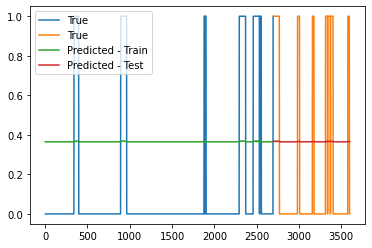

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.587205 --> 0.541234).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.541234 --> 0.290969).  Saving model ...
Validation loss decreased (0.290969 --> 0.176703).  Saving model ...
Validation loss decreased (0.176703 --> 0.102809).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.102809 --> 0.100028).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.100028 --> 0.089335).  Saving model ...
EarlyStopping counter: 1 out of 5
epoch= 10,loss= 0.2422405630350113
time costed is 41.71823859214783


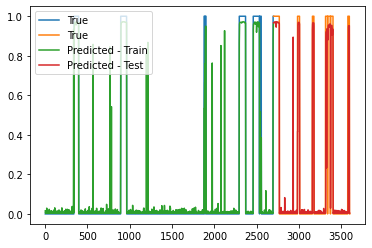

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.089335 --> 0.082761).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.082761 --> 0.078272).  Saving model ...
Validation loss decreased (0.078272 --> 0.076634).  Saving model ...
Validation loss decreased (0.076634 --> 0.072018).  Saving model ...
Validation loss decreased (0.072018 --> 0.068776).  Saving model ...
Validation loss decreased (0.068776 --> 0.065114).  Saving model ...
Validation loss decreased (0.065114 --> 0.062384).  Saving model ...
Validation loss decreased (0.062384 --> 0.059300).  Saving model ...
Validation loss decreased (0.059300 --> 0.057010).  Saving model ...
epoch= 20,loss= 0.14362479746341705
time costed is 42.18796515464783


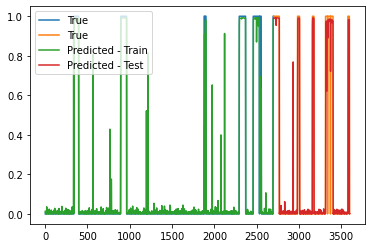

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.057010 --> 0.054193).  Saving model ...
Validation loss decreased (0.054193 --> 0.052060).  Saving model ...
Validation loss decreased (0.052060 --> 0.050536).  Saving model ...
Validation loss decreased (0.050536 --> 0.048764).  Saving model ...
Validation loss decreased (0.048764 --> 0.047643).  Saving model ...
Validation loss decreased (0.047643 --> 0.046085).  Saving model ...
Validation loss decreased (0.046085 --> 0.045047).  Saving model ...
Validation loss decreased (0.045047 --> 0.044005).  Saving model ...
Validation loss decreased (0.044005 --> 0.043001).  Saving model ...
Validation loss decreased (0.043001 --> 0.042195).  Saving model ...
epoch= 30,loss= 0.09637082368135452
time costed is 42.270206928253174


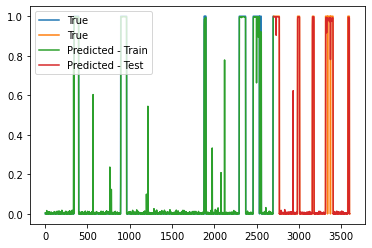

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.042195 --> 0.041409).  Saving model ...
Validation loss decreased (0.041409 --> 0.040709).  Saving model ...
Validation loss decreased (0.040709 --> 0.040086).  Saving model ...
Validation loss decreased (0.040086 --> 0.039577).  Saving model ...
Validation loss decreased (0.039577 --> 0.039000).  Saving model ...
Validation loss decreased (0.039000 --> 0.038467).  Saving model ...
Validation loss decreased (0.038467 --> 0.037968).  Saving model ...
Validation loss decreased (0.037968 --> 0.037590).  Saving model ...
Validation loss decreased (0.037590 --> 0.037425).  Saving model ...
Validation loss decreased (0.037425 --> 0.037156).  Saving model ...
epoch= 40,loss= 0.08514144271612167
time costed is 42.107306718826294


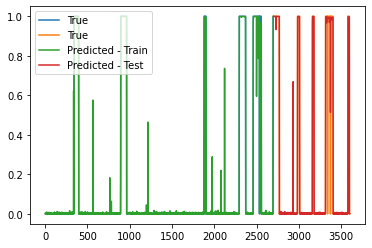

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.037156 --> 0.036860).  Saving model ...
Validation loss decreased (0.036860 --> 0.036384).  Saving model ...
Validation loss decreased (0.036384 --> 0.036125).  Saving model ...
Validation loss decreased (0.036125 --> 0.035919).  Saving model ...
Validation loss decreased (0.035919 --> 0.035332).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.035332 --> 0.034733).  Saving model ...
Validation loss decreased (0.034733 --> 0.034529).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.034529 --> 0.034287).  Saving model ...
epoch= 50,loss= 0.07895732671022415
time costed is 42.083950996398926


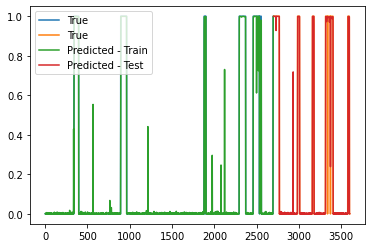

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.034287 --> 0.033958).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.033958 --> 0.033692).  Saving model ...
Validation loss decreased (0.033692 --> 0.033304).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Validation loss decreased (0.033304 --> 0.032609).  Saving model ...
Validation loss decreased (0.032609 --> 0.032264).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
epoch= 60,loss= 0.07488898932933807
time costed is 42.26206016540527


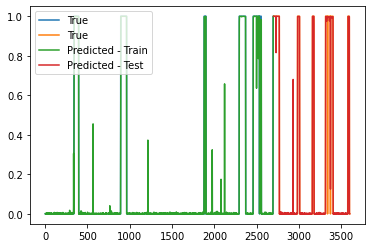

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
Validation loss decreased (0.032264 --> 0.032169).  Saving model ...
Validation loss decreased (0.032169 --> 0.031171).  Saving model ...
Validation loss decreased (0.031171 --> 0.030859).  Saving model ...
Validation loss decreased (0.030859 --> 0.030668).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Validation loss decreased (0.030668 --> 0.030623).  Saving model ...
Validation loss decreased (0.030623 --> 0.030488).  Saving model ...
epoch= 70,loss= 0.06864980608224869
time costed is 41.71525478363037


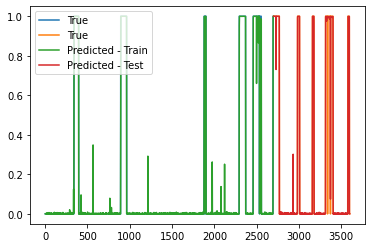

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Validation loss decreased (0.030488 --> 0.030294).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.030294 --> 0.030003).  Saving model ...
Validation loss decreased (0.030003 --> 0.029983).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.029983 --> 0.029349).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.029349 --> 0.028607).  Saving model ...
epoch= 80,loss= 0.0637812465429306
time costed is 42.38429832458496


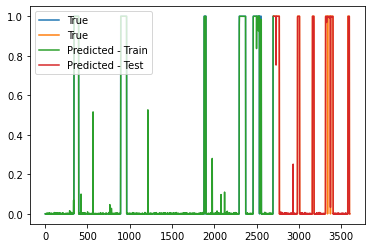

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


In [174]:
import time
time_start=time.time()
#train wind speed
n_iter=0
y_target=np.zeros((BATCH_SIZE,1))
for epoch in range(EPOCH):
    
    #perm_idx = np.random.permutation(TRAINSIZE - T)
    perm_idx=np.array(range(sample1))
    j = 0
    while j < sample1:
        batch_idx = perm_idx[j:(j + BATCH_SIZE)]
#         X_history = np.zeros((len(batch_idx), T +step, COLUMN))
#         Y_history = np.zeros((len(batch_idx), T +step))
        X_history=X1[batch_idx]
        Y_history=Y1[batch_idx]
        y_target[:,0] =y_train_label[batch_idx]
       

#         for k in range(len(batch_idx)):
#             X_history[k, :, :] = X1[batch_idx[k] : (batch_idx[k]+ T+step ), :]
#             Y_history[k, :] = Y1[batch_idx[k] : (batch_idx[k] + T +step)]
           
        
        optimizer.zero_grad()

        y_pred = model(Variable(torch.from_numpy(X_history).type(torch.FloatTensor).cuda()),
                       Variable(torch.from_numpy(Y_history).type(torch.FloatTensor).cuda()))
        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor).cuda())
        #print(y_pred.shape)
        l1_reg=0
        for param in model.parameters():
            l1_reg+=torch.sum(torch.abs(param))
        loss = criterion(y_pred, y_true)
        total_loss=loss+k1*l1_reg
        total_loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())
        j += BATCH_SIZE
    #'''
        n_iter+=1
        if n_iter % 200 == 0 and n_iter > 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * 0.9
    #'''
    #calculate the vaidation loss
    
    y_pred_valid = predict(on_train = False)
    loss_valid = criterion(Variable(torch.from_numpy(y_pred_valid).type(torch.FloatTensor).cuda()), 
                         Variable(torch.from_numpy(y_valid_label).type(torch.FloatTensor).cuda()))
    # record validation loss
    valid_losses.append(loss_valid.item())
    valid_loss_iter=loss_valid.item()
    
    #calculate the train loss
    y_pred_train = predict(on_train = True)   
    loss_train = criterion(Variable(torch.from_numpy(y_pred_train).type(torch.FloatTensor).cuda()), 
                         Variable(torch.from_numpy(y_train_label).type(torch.FloatTensor).cuda()))
    # record validation loss
    train_losses.append(loss_train.item())
    train_loss_iter=loss_train.item()
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    early_stopping(valid_loss_iter, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    if epoch % 10 == 0:
        time_end=time.time()
        time_cost=time_end-time_start
        print(f'epoch= {epoch},loss= {loss}')
        print(f'time costed is {time_cost}')
        time_start=time_end
    if epoch % 10 == 0:
        #y_train_pred = predict(on_train = True)
        #y_test_pred = predict(on_train = False)
        #y_pred = np.concatenate((y_train_pred, y_test_pred))
        #print(y_pred)
        plt.figure()
        plt.plot(range(1, 1 + len(y_train_label)), y_train_label, label = "True")
        plt.plot(range(1+len(y_train_label), 1 +len(y_train_label)+len(y_valid_label)), y_valid_label, label = "True")
        plt.plot(range(1 , 1+len(y_pred_train)), y_pred_train, label = 'Predicted - Train')
        plt.plot(range(1+len(y_pred_train) , 1+len(y_pred_train)+len(y_pred_valid) ), y_pred_valid, label = 'Predicted - Test')
        plt.legend(loc = 'upper left')
        plt.show()


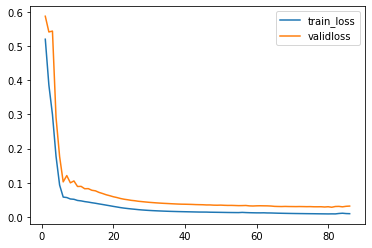

In [175]:
plt.figure()
plt.plot(range(1, 1+len(train_losses)), train_losses, label = "train_loss")
plt.plot(range(1, 1+len(valid_losses)), valid_losses, label = "validloss")
plt.legend(loc = 'upper right')
# plt.savefig('/home/liuchen/DARNN/high-results/DARNN picture/K117_14_loss.png',dpi=120)
plt.show()

In [67]:

##测试集
X_test= X0[127600:149200+T+step]
#targt series
Y_test= Y0[127600:149200+T+step]
y_bag_label=mil_label[127600:149200]

y_bag_pred=np.zeros((len(y_bag_label)))
i=0
while i < len(y_bag_pred):
        batch_idx = np.array(range(len(y_bag_pred)))[i : (i + BATCH_SIZE)]
        X = np.zeros((len(batch_idx), T+step, COLUMN))
        y_history = np.zeros((len(batch_idx),T+step ))
        for j in range(len(batch_idx)):
            X[j, :, :] = X_test[range(batch_idx[j], batch_idx[j] + T+ step ), :]
            y_history[j, :] = Y_test[range(batch_idx[j],  batch_idx[j]+ T+step )]
            
        

            #_, input_encoded = encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()))
            #input_final=decoder(input_encoded,Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda()))
            #print(input_final)
            #print(mil(input_final).cpu().data.numpy()[:, 0])
        y_bag_pred[i:(i + BATCH_SIZE)] = model(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()),
                                              Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())).cpu().data.numpy()[:, 0]
            #print('here1')
            #y_pred[i:(i + BATCH_SIZE)] = mil(Variable(torch.from_numpy(input_final).type(torch.FloatTensor).cuda()))
            #y_pred.append(mil(input_final))
        i += BATCH_SIZE
        
plt.figure(figsize=(10,6))
plt.plot(range(1, 1 +len(y_bag_label)), y_bag_label, label = "True")
plt.plot(range(1 , 1+len(y_bag_pred)), y_bag_pred, label = 'Predicted - Test')
plt.legend(loc = 'upper left')
# plt.savefig('/home/liuchen/DARNN/high-results/DARNN picture/K117_14_pred.png',dpi=120)
plt.show()


# BATCH_SIZE2=2160
# ##测试instance
# X_test_instance= X0[127600:len(X0)-step]
# #targt series
# Y_test_instance= Y0[127600:len(Y0)-step]
# y_instance_label=y_label[127600+T:len(Y0)-step]

# y_instance_pred=np.zeros((len(y_instance_label)))

# batch_idx = np.array(range(int(len(y_instance_pred)/10)))*10

# X = np.zeros((len(batch_idx), T +step, COLUMN))
# y_history = np.zeros((len(batch_idx),T +step))
# for j in range(len(batch_idx)):
#     X[j, :, :] = X_test_instance[range(batch_idx[j], batch_idx[j] + T +step), :]
#     y_history[j, :] = Y_test_instance[range(batch_idx[j],  batch_idx[j]+ T +step)]


#     #_, input_encoded = encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()))
#     #input_final=decoder(input_encoded,Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda()))
#     #print(input_final)
#     #print(mil(input_final).cpu().data.numpy()[:, 0])

# y_instance_pred= model.evaluate(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()),
#                         Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())).cpu().data.numpy().reshape(len(y_instance_label))
#     #print('here1')
#     #y_pred[i:(i + BATCH_SIZE)] = mil(Variable(torch.from_numpy(input_final).type(torch.FloatTensor).cuda()))
#     #y_pred.append(mil(input_final))

# plt.figure(figsize=(10,6))
# plt.plot(range(1, 1 + len(y_instance_label)), y_instance_label, label = "True")
# plt.plot(range(1 , len(y_instance_pred) +1), y_instance_pred, label = 'Predicted - Test')
# plt.legend(loc = 'upper left')
# plt.show()


/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

0.7959183673469388
0.9397590361445783
0.0011041733566292873
0.6774193548387096
0.8936170212765957
0.0011355189301425926


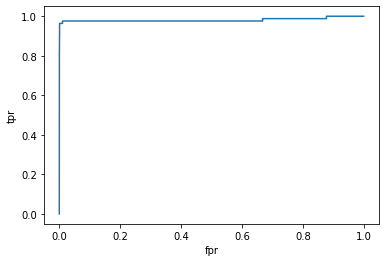

0.9810864035217881


In [23]:
y_pred_bag=np.zeros((len(y_bag_pred)))
y_pred_bag[y_bag_pred>0.5]=1
y_pred_instance=np.zeros((len(y_instance_pred)))
y_pred_instance[y_instance_pred>0.5]=1
from sklearn.metrics import precision_score,recall_score,mean_squared_error
print(precision_score(y_bag_label,y_pred_bag))
print(recall_score(y_bag_label,y_pred_bag))
print(mean_squared_error(y_bag_label,y_bag_pred))
print(precision_score(y_instance_label,y_pred_instance))
print(recall_score(y_instance_label,y_pred_instance))
print(mean_squared_error(y_instance_label,y_instance_pred))

##ROC曲线
from sklearn.metrics import roc_curve,auc
y_bag_label=mil_label[127600:len(Y0)-T-step]

fpr,tpr,thresholds= roc_curve(y_bag_label,y_bag_pred,pos_label=1)
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
# plt.savefig('/home/liuchen/DARNN/high-results/DARNN picture/K117_14_ROC.png',dpi=120)
plt.show()
AUC=auc(fpr,tpr)
print(AUC)

In [68]:
model=torch.load('/home/liuchen/WSP/DARNN/DA-results/DARNN_new_model/K135_15.pth')
##测试集
X_test= X0[127600:149200+T+step]
#targt series
Y_test= Y0[127600:149200+T+step]
y_bag_label=mil_label[127600:149200]

attention=np.zeros((len(y_bag_label),step,T,in_dim))
i=0
while i < len(y_bag_pred):
        batch_idx = np.array(range(len(y_bag_pred)))[i : (i + BATCH_SIZE)]
        X = np.zeros((len(batch_idx), T+step, COLUMN))
        y_history = np.zeros((len(batch_idx),T+step ))
        for j in range(len(batch_idx)):
            X[j, :, :] = X_test[range(batch_idx[j], batch_idx[j] + T+ step ), :]
            y_history[j, :] = Y_test[range(batch_idx[j],  batch_idx[j]+ T+step )]
            
        

            #_, input_encoded = encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()))
            #input_final=decoder(input_encoded,Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda()))
            #print(input_final)
            #print(mil(input_final).cpu().data.numpy()[:, 0])
        attention[i:(i + BATCH_SIZE)] = model.attention(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()),
                                              Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())).cpu().data.numpy()
            #print('here1')
            #y_pred[i:(i + BATCH_SIZE)] = mil(Variable(torch.from_numpy(input_final).type(torch.FloatTensor).cuda()))
            #y_pred.append(mil(input_final))
        i += BATCH_SIZE

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:176: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:203: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
